# Algorithmic Trading Project: Statistical Arbitrage

## 1. Project Objective

Inspired by quantitative finance competitions like the **"Quantitative Edge Challenge" by J.P. Morgan and AmplifyME**, my objective with this project was to develop a complete and coherent backtesting environment from the ground up. I wanted to recreate a tool similar to those used in these challenges to implement an algorithmic trading strategy.

The strategy I am implementing here is **statistical arbitrage**, also known as *pairs trading*: a market-neutral strategy that involves trading the spread between two highly correlated assets, betting on its mean reversion. The fundamental principle is *mean reversion*: the statistical tendency of a variable to return to its long-term average. The bet is that extreme deviations are temporary.

For this to work, my hypothesis is that the performance spread between an ETF (QQQ) and a synthetic basket of stocks is *stationary*: a property of a signal whose statistical characteristics (like mean and variance) are constant over time, thus making it predictable.

In [162]:
# 1. IMPORTS AND CONFIGURATION

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta

plt.style.use('dark_background')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

## 2. Development of the Backtesting Engine

To simulate my trades realistically, I created my own backtesting engine in Python. It is composed of two classes (`Position` and `MyTradingEnginePro`) to manage the portfolio, orders, commissions, and performance logging. I also developed a `create_trading_dashboard` function that generates the final visual report.

This cell contains all the "mechanics" and does not need to be modified.

In [163]:
# 2. TRADING ENGINE, CALCULATION TOOLS, AND DASHBOARD

# --- Position Class ---
class Position:
    """Represents a single asset position."""
    def __init__(self, ticker):
        self.ticker = ticker
        self.volume = 0
        self.avg_entry_price = 0.0
        self.realized_pnl = 0.0

    def update(self, transaction_volume, price):
        """Updates position on a transaction and returns realized P&L."""
        total_cost_before = self.volume * self.avg_entry_price
        pnl_from_trade = 0.0
        
        is_closing = (self.volume > 0 and transaction_volume < 0) or \
                     (self.volume < 0 and transaction_volume > 0)

        if is_closing:
            volume_closed = min(abs(self.volume), abs(transaction_volume))
            pnl = volume_closed * (price - self.avg_entry_price)
            if self.volume < 0: 
                pnl = -pnl
            self.realized_pnl += pnl
            pnl_from_trade = pnl

        new_total_volume = self.volume + transaction_volume
        if new_total_volume != 0:
            if not is_closing:
                total_cost_after = total_cost_before + (transaction_volume * price)
                self.avg_entry_price = total_cost_after / new_total_volume
        else: # Position fully closed
            self.avg_entry_price = 0
        
        self.volume = new_total_volume
        return pnl_from_trade
        
    def get_unrealized_pnl(self, current_price):
        """Calculates the current unrealized P&L."""
        if self.volume == 0:
            return 0.0
        return self.volume * (current_price - self.avg_entry_price)

# --- The "Pro" Trading Engine ---
class MyTradingEnginePro:
    """Orchestrates the backtest, manages portfolio, and records performance."""
    def __init__(self, initial_balance=1_000_000, commission_rate=0.0005):
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.commission_rate = commission_rate
        self.positions = {}
        self.trade_log = []
        self.equity_history = []

    def execute_order(self, ticker, volume, action, price, timestamp):
        """Executes a trade order and updates the portfolio."""
        if volume <= 0 or price <= 0: return
        
        trade_value = volume * price
        commission = trade_value * self.commission_rate
        self.balance -= commission
        
        transaction_volume = volume if action.upper() == 'BUY' else -volume
        
        if action.upper() == 'BUY':
            self.balance -= trade_value
        else: # SELL
            self.balance += trade_value
            
        if ticker not in self.positions:
            self.positions[ticker] = Position(ticker)
            
        pnl_from_trade = self.positions[ticker].update(transaction_volume, price)
        
        self.trade_log.append({
            'timestamp': timestamp,
            'ticker': ticker,
            'action': action,
            'volume': volume,
            'price': price,
            'commission': commission,
            'realized_pnl': pnl_from_trade
        })

    def get_portfolio_value(self, current_prices):
        """Calculates the total portfolio value (cash + asset value)."""
        assets_value = 0.0
        for ticker, position in self.positions.items():
            assets_value += position.volume * current_prices.get(ticker, 0)
        return self.balance + assets_value

    def record_timestamp(self, timestamp, current_prices):
        """Records the full portfolio state, including market exposure."""
        unrealized_pnl = 0.0
        long_exposure = 0.0
        short_exposure = 0.0
        
        for ticker, position in self.positions.items():
            price = current_prices.get(ticker, 0)
            unrealized_pnl += position.get_unrealized_pnl(price)
            
            position_value = abs(position.volume) * price
            if position.volume > 0:
                long_exposure += position_value
            elif position.volume < 0:
                short_exposure += position_value
            
        realized_pnl = sum(pos.realized_pnl for pos in self.positions.values())
        net_pnl = realized_pnl + unrealized_pnl
        portfolio_value = self.initial_balance + net_pnl
        
        net_exposure = long_exposure - short_exposure
        
        self.equity_history.append({
            'timestamp': timestamp, 
            'portfolio_value': portfolio_value,
            'realized_pnl': realized_pnl,
            'unrealized_pnl': unrealized_pnl,
            'net_pnl': net_pnl,
            'net_exposure': net_exposure
        })
    
    def get_results(self):
        """Returns simulation results as DataFrames."""
        if not self.equity_history: return None
        equity_df = pd.DataFrame(self.equity_history).set_index('timestamp')
        trades_df = pd.DataFrame(self.trade_log).set_index('timestamp')
        return {'equity_curve': equity_df, 'trades': trades_df}

# --- Performance Calculation Functions ---
def calculate_performance_metrics(equity_curve, trades, initial_balance):
    """Calculates all key performance indicators (KPIs)."""
    metrics = {}
    metrics['realized_pnl'] = trades['realized_pnl'].sum()
    metrics['return_on_capital'] = (equity_curve['portfolio_value'].iloc[-1] / initial_balance) - 1
    metrics['total_trades'] = len(trades)
    winning_trades = trades[trades['realized_pnl'] > 0]
    metrics['win_ratio'] = len(winning_trades) / metrics['total_trades'] if metrics['total_trades'] > 0 else 0
    returns = equity_curve['portfolio_value'].pct_change().dropna()
    metrics['annual_volatility'] = returns.std() * np.sqrt(252) if not returns.empty else 0.0
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() != 0 else 0
    metrics['sharpe_ratio'] = sharpe_ratio
    cumulative_returns = (1 + returns).cumprod()
    if not cumulative_returns.empty:
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns / peak) - 1
        metrics['max_drawdown'] = drawdown.min()
    else:
        metrics['max_drawdown'] = 0.0
    return metrics

# --- Dashboard Plotting Function (Final Version with Parameters) ---
def create_trading_dashboard(engine, strategy_params={}):
    """Generates a complete visual performance dashboard, including strategy parameters."""
    results = engine.get_results()
    if not results or results['equity_curve'].empty:
        print("The engine has no history to analyze.")
        return

    equity_curve = results['equity_curve']
    trades = results['trades']
    metrics = calculate_performance_metrics(equity_curve, trades, engine.initial_balance)
    last_pnl = equity_curve.iloc[-1]
    
    fig = plt.figure(figsize=(16, 18))
    fig.patch.set_facecolor('#121212')
    fig.suptitle('Strategy Performance Dashboard', fontsize=24, weight='bold')
    
    gs = fig.add_gridspec(4, 1, height_ratios=[2, 2, 1, 2.5])

    # --- PLOT 1: Equity Curve ---
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(equity_curve.index, equity_curve['portfolio_value'], color='#6bbdff', linewidth=2, label='Portfolio Value')
    ax0.set_facecolor('#1e1e1e')
    ax0.set_title('Portfolio Value (Equity Curve)', fontsize=18, weight='bold', pad=20)
    ax0.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, color='#555555')
    ax0.legend(fontsize=12)
    ax0.set_ylabel("Total Value ($)")

    # --- PLOT 2: P&L Decomposition ---
    ax1 = fig.add_subplot(gs[1])
    ax1.plot(equity_curve.index, equity_curve['net_pnl'], color='white', linewidth=1.5, label='Net P&L')
    ax1.plot(equity_curve.index, equity_curve['realized_pnl'], color='#2ca02c', linestyle='--', linewidth=1.5, label='Realized P&L')
    ax1.fill_between(equity_curve.index, equity_curve['unrealized_pnl'], 0, color='#ff9999', alpha=0.4, label='Unrealized P&L')
    ax1.set_facecolor('#1e1e1e')
    ax1.set_title('P&L Decomposition', fontsize=18, weight='bold', pad=20)
    ax1.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, color='#555555')
    ax1.legend(fontsize=12)
    ax1.set_ylabel("Profit & Loss ($)")

    # --- PLOT 3: Net Market Exposure ---
    ax2 = fig.add_subplot(gs[2])
    ax2.plot(equity_curve.index, equity_curve['net_exposure'], color='#ffb3e6', linewidth=1.5, label='Net Exposure')
    ax2.axhline(0, color='white', linestyle='--', linewidth=0.5)
    ax2.set_facecolor('#1e1e1e')
    ax2.set_title('Net Market Exposure', fontsize=18, weight='bold', pad=20)
    ax2.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, color='#555555')
    ax2.legend(fontsize=12)
    ax2.set_ylabel("Net Value ($)")

    # --- SECTION 4: KPIs and Pie Charts ---
    gs3 = gs[3].subgridspec(1, 3, wspace=0.3)
    
    ax3_kpi = fig.add_subplot(gs3[0])
    ax3_kpi.axis('off')

    params_text = (
        f"\n\n--- Strategy Parameters ---\n"
        f"Window: {strategy_params.get('window', 'N/A')}\n"
        f"Entry Z-Score: {strategy_params.get('entry', 'N/A'):.2f}\n"
        f"Exit Z-Score: {strategy_params.get('exit', 'N/A'):.2f}"
    )
    
    kpi_text = (f"Net P&L: ${last_pnl['net_pnl']:,.2f}\n"
                f"  └ Realized P&L: ${last_pnl['realized_pnl']:,.2f}\n"
                f"  └ Unrealized P&L: ${last_pnl['unrealized_pnl']:,.2f}\n\n"
                f"Return on Capital: {metrics['return_on_capital']:.2%}\n"
                f"Total Trades: {metrics['total_trades']}\n"
                f"Win Ratio: {metrics['win_ratio']:.2%}\n"
                f"Max Drawdown: {metrics['max_drawdown']:.2%}\n"
                f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}"
                f"{params_text}"
               )

    ax3_kpi.text(0.5, 0.5, kpi_text, ha='center', va='center', fontsize=12,
                 bbox=dict(boxstyle="round,pad=1.5", fc="#1f2c56", ec="lightsteelblue", lw=1))
    ax3_kpi.set_title('Performance & Parameters', fontsize=18, weight='bold', pad=20)

    ax3_pie1 = fig.add_subplot(gs3[1])
    top_assets = trades['ticker'].value_counts().nlargest(6)
    colors_pie = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6']
    ax3_pie1.pie(top_assets.values, labels=top_assets.index, autopct='%1.1f%%',
                 startangle=90, colors=colors_pie, wedgeprops={'edgecolor': '#121212', 'linewidth': 2}, textprops={'fontsize': 12})
    ax3_pie1.set_title('Top Traded Assets', fontsize=18, weight='bold', pad=20)
    
    ax3_pie2 = fig.add_subplot(gs3[2])
    wins = (trades['realized_pnl'] > 0).sum()
    losses = (trades['realized_pnl'] < 0).sum()
    if wins > 0 or losses > 0:
        ax3_pie2.pie([wins, losses], labels=['Gains', 'Losses'], autopct='%1.1f%%',
                     startangle=90, colors=['#2ca02c', '#d62728'], wedgeprops={'edgecolor': '#121212', 'linewidth': 2}, textprops={'fontsize': 12})
    else:
        ax3_pie2.text(0.5, 0.5, 'No completed trades', ha='center', va='center', alpha=0.7)
        ax3_pie2.axis('off')
    ax3_pie2.set_title('Win/Loss Ratio', fontsize=18, weight='bold', pad=20)
    
    plt.tight_layout(pad=3.0)
    plt.show()

print("Trading engine and analysis tools are ready.")

Trading engine and analysis tools are ready.


## 3. Data Preparation

For this project, I am fetching stock data via the `yfinance` library. I've selected a 2-year period to have a robust sample and test the strategy on different market conditions. The chosen reference ETF is QQQ (representing the Nasdaq-100), which I rename 'FAANG' to align with the challenge's theme. 

The code is designed to be robust by downloading each asset individually to avoid errors and ensuring all data is present before continuing.

In [164]:
# 3. DATA LOADING

end_date = datetime.now()
start_date = end_date - timedelta(days=1 * 365)
tickers = ['AAPL', 'AMZN', 'META', 'GOOGL', 'NFLX', 'QQQ']
all_series = []

for ticker in tickers:
    try:
        data = yf.download(ticker, start=start_date, end=end_date, interval="1d", progress=False, auto_adjust=True)
        if not data.empty and 'Close' in data.columns:
            close_series = data['Close']
            close_series.name = ticker
            all_series.append(close_series)
    except Exception as e:
        print(f"  /!\\ ERROR downloading {ticker}: {e}")

historical_prices = pd.concat(all_series, axis=1).dropna()

historical_prices.rename(columns={'META': 'FB', 'QQQ': 'FAANG'}, inplace=True)

required_columns = ['AAPL', 'AMZN', 'FB', 'GOOGL', 'NFLX', 'FAANG']

if not all(col in historical_prices.columns for col in required_columns):
    print("\nERROR: Missing data after assembly. Halting.")
else:
    print(f"Data available from {historical_prices.index.min().date()} to {historical_prices.index.max().date()}.")

Data available from 2024-11-04 to 2025-10-31.


## 4. My Strategy: Betting on the "Elastic Band Effect"

Here, I define and test my trading logic. The idea is to model the relationship between my two assets (the real ETF and the synthetic one) as if they were connected by an **invisible elastic band**.

### Step 1: Creating the Elastic Band (The `diff` signal)

To begin, I need to be able to compare my two assets on the same basis. I therefore normalize their prices so they both start at a value of 100 on the first day. This allows me to compare their percentage performance.

The spread between these two performances is my `diff` signal. It's the **length of my elastic band** at any given moment.

### Step 2: Measuring the Band's Tension (The Z-Score)

The problem is that sometimes both assets can drift up or down together, while maintaining a constant spread. I'm not interested in the *position* of the assets, but rather the **tension** of the elastic band connecting them.

This is where the *Z-Score* comes in. It's my "tension gauge." It ignores the general market direction and only measures how much the elastic is stretched compared to its usual tension (calculated over the last 60 days).

Here's how I interpret the readings from this gauge:
* **Z-Score > 2:** The elastic is **abnormally stretched** in one direction. The snap-back force should cause it to contract. **TRADE SIGNAL!**
* **Z-Score < -2:** The elastic is **abnormally stretched** in the other direction. The snap-back force should also cause it to contract. **TRADE SIGNAL!**
* **Z-Score near 0:** The elastic is relaxed, at its resting length. The situation is normal, we do nothing.

### Step 3: Defining the Rules of the Game (The Trading Strategy)

My strategy is based directly on the tension gauge reading:
1.  **I open a position** as soon as the elastic is very tight (Z-score > 2 or < -2), betting on its return to normal.
2.  **I close my position** (and take my profit/loss) as soon as the elastic is relaxed again (Z-score has returned close to 0).

---
To try and maximize the strategy's performance (P&L, Sharpe ratio, etc.), I primarily play with three "dials" in the code cell below. Each simulation is realistic as it includes a **0.05% commission on every transaction**. The optimization levers are:
* `window`: The "memory" of the signal, i.e., the calculation period for the mean and standard deviation.
* `entry_threshold`: The strategy's selectivity, or the level of "tension" in the elastic needed to trigger a trade.
* `exit_threshold`: The reactivity of the exit, or the level of "relaxation" that tells me to close the trade.

In [165]:
# 4.1. SIGNAL CALCULATION

components = ['AAPL', 'AMZN', 'FB', 'GOOGL', 'NFLX']
rebased_prices = pd.DataFrame()

for ticker in components:
    rebased_prices[ticker] = (historical_prices[ticker] / historical_prices[ticker].iloc[0]) * 100

synthetic_etf = rebased_prices.mean(axis=1)
rebased_faang = (historical_prices['FAANG'] / historical_prices['FAANG'].iloc[0]) * 100
diff = rebased_faang - synthetic_etf
window=10

rolling_mean = diff.rolling(window=window).mean()
rolling_std = diff.rolling(window=window).std()

z_score = (diff - rolling_mean) / rolling_std
print(z_score.describe())

count    240.000000
mean       0.019689
std        1.200086
min       -2.520954
25%       -1.072113
50%        0.044688
75%        1.021502
max        2.507524
dtype: float64


### 4.2. Parameters and Visualization

This is where I define all the levers of my strategy. I can adjust these parameters and re-run this cell quickly to see the signal graph with the new thresholds, before launching the full backtest.

Here are the parameters I chose here:  {'window': 10, 'entry': 1, 'exit': 0.1}


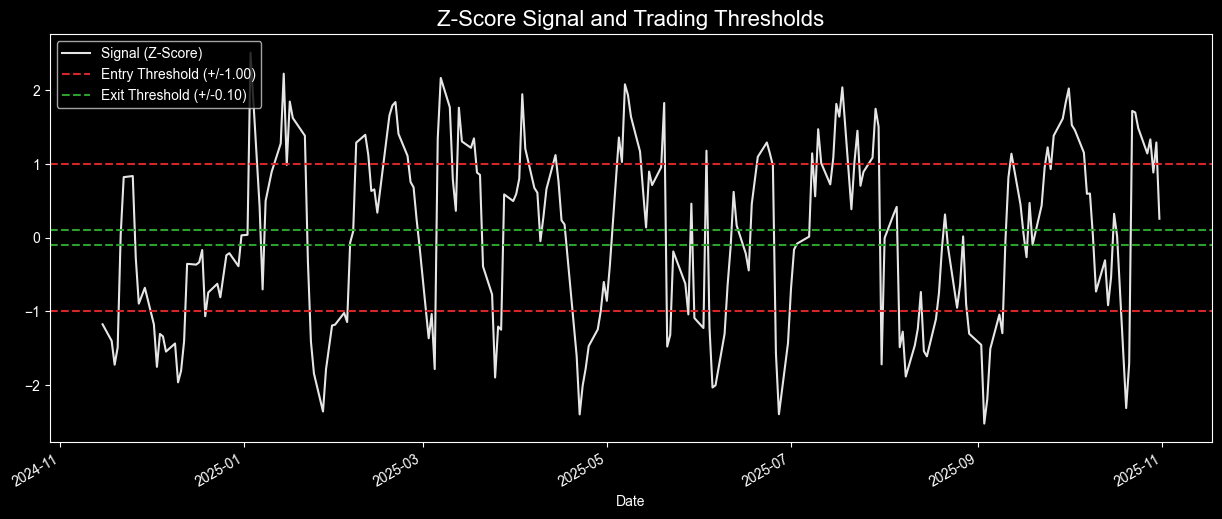

In [166]:
# 4.2. PARAMETERS & VISUALIZATION 

# Lever 1: Entry/Exit Timing ---
entry_threshold = 1
exit_threshold = 0.1

# Lever 2: Calculation Window ---
window = 10

# Lever 3: Position Sizing ---
trade_volume_etf = 1000
trade_volume_stock = 200

strategy_params = {'window': window, 'entry': entry_threshold, 'exit': exit_threshold}
print("Here are the parameters I chose here: ", strategy_params)


# Signal Visualization
plt.figure(figsize=(15, 6))
z_score.plot(label='Signal (Z-Score)', color='white', alpha=0.9)
plt.axhline(entry_threshold, color='#d62728', linestyle='--', label=f'Entry Threshold (+/-{entry_threshold:.2f})')
plt.axhline(-entry_threshold, color='#d62728', linestyle='--')
plt.axhline(exit_threshold, color='#2ca02c', linestyle='--', label=f'Exit Threshold (+/-{exit_threshold:.2f})')
plt.axhline(-exit_threshold, color='#2ca02c', linestyle='--')
plt.title('Z-Score Signal and Trading Thresholds', fontsize=16)
plt.legend(); plt.show()

### 4.3. Simulation Execution (Backtest)

This cell takes the signal and parameters defined above and runs the trading simulation over the entire history.

In [167]:
# 4.3. EXECUTE BACKTEST

engine = MyTradingEnginePro(initial_balance=1_000_000)
trade_state, trade_queue, position_type = 'IDLE', [], None

for timestamp, row in historical_prices.iterrows():
    current_prices = row; current_z_score = z_score.loc[timestamp]
    if pd.isna(current_z_score):
        engine.record_timestamp(timestamp, current_prices); continue
    
    if trade_state == 'ENTERING':
        if trade_queue:
            ticker, volume, action = trade_queue.pop(0)
            engine.execute_order(ticker, volume, action, current_prices[ticker], timestamp)
        if not trade_queue: trade_state = 'IN_POSITION'
    elif trade_state == 'EXITING':
        if trade_queue:
            ticker, volume, action = trade_queue.pop(0)
            engine.execute_order(ticker, volume, action, current_prices[ticker], timestamp)
        if not trade_queue: trade_state = 'IDLE'
    elif trade_state == 'IN_POSITION':
        if abs(current_z_score) < exit_threshold:
            trade_state = 'EXITING'
            for t, pos in list(engine.positions.items()):
                if pos.volume != 0:
                    action_to_close = 'SELL' if pos.volume > 0 else 'BUY'
                    trade_queue.append((t, abs(pos.volume), action_to_close))
            if trade_queue:
                ticker, volume, action = trade_queue.pop(0)
                engine.execute_order(ticker, volume, action, current_prices[ticker], timestamp)
    elif trade_state == 'IDLE':
        if current_z_score > entry_threshold:
            trade_state = 'ENTERING'; position_type = 'SHORT_ETF'
            trade_queue = [('FAANG', trade_volume_etf, 'SELL')] + [(comp, trade_volume_stock, 'BUY') for comp in components]
        elif current_z_score < -entry_threshold:
            trade_state = 'ENTERING'; position_type = 'LONG_ETF'
            trade_queue = [('FAANG', trade_volume_etf, 'BUY')] + [(comp, trade_volume_stock, 'SELL') for comp in components]
        if trade_state == 'ENTERING':
            if trade_queue:
                ticker, volume, action = trade_queue.pop(0)
                engine.execute_order(ticker, volume, action, current_prices[ticker], timestamp)
    engine.record_timestamp(timestamp, current_prices)

## 5. Results Visualization

This final cell executes the dashboarding function to generate the visual report for the simulation. This is the moment of truth, where I analyze the results of the latest parameter configuration to decide on the next optimization steps.

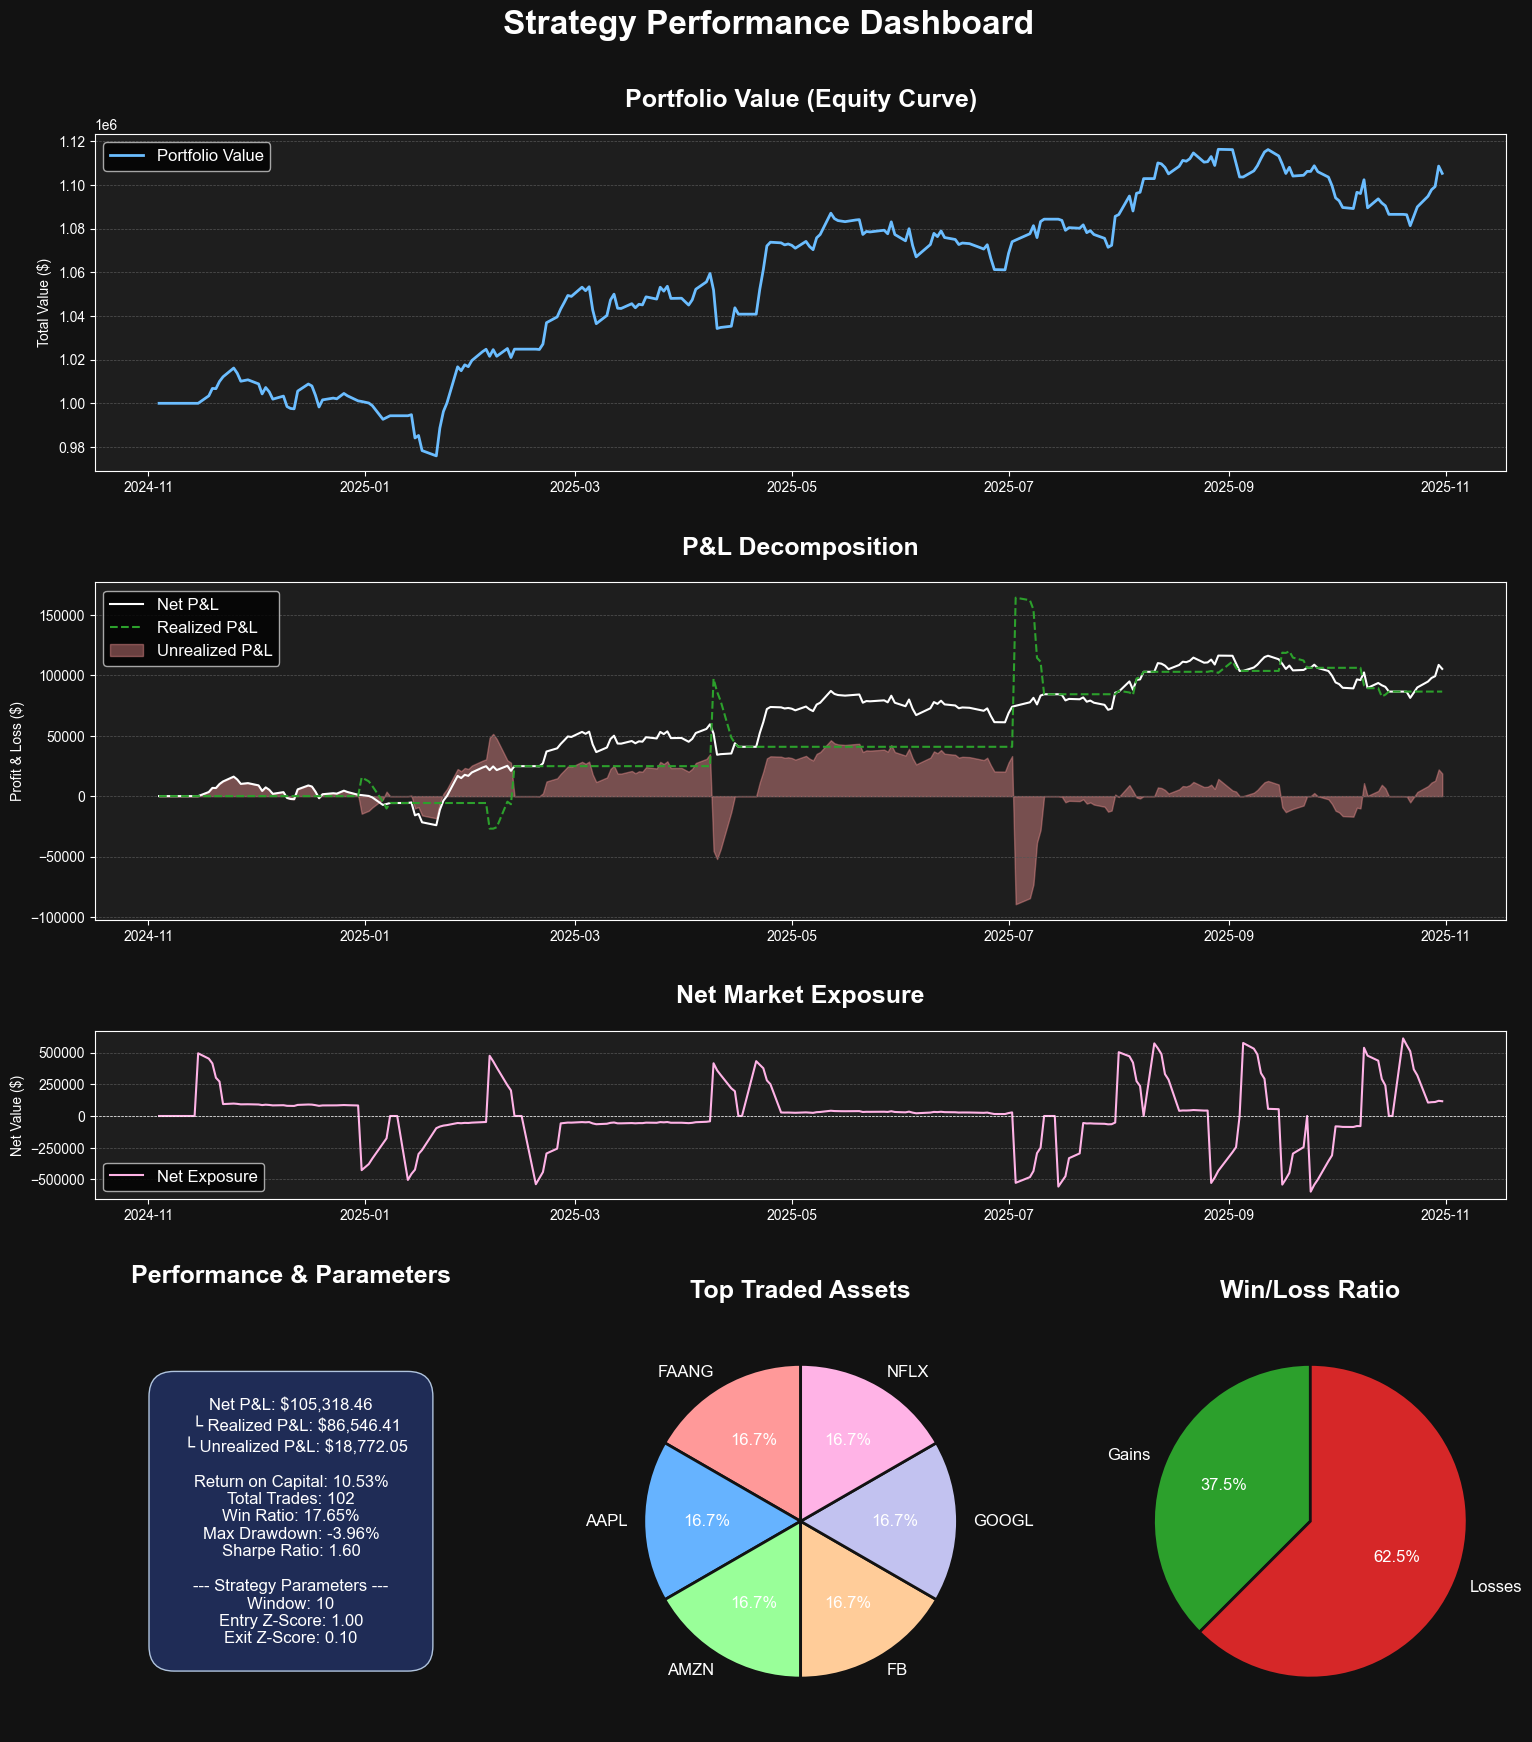

In [168]:
# 5. DISPLAY DASHBOARD

create_trading_dashboard(engine, strategy_params)

## 6. Interpreting the Performance Indicators (KPIs)

Evaluating a trading strategy goes beyond its final profit. The following indicators, presented in the dashboard, help to rigorously analyze its behavior, efficiency, and risk profile.

---

* **Net P&L**
    This is the global, total performance of the strategy at a given moment. It represents the sum of the already-cashed-in P&L and the latent P&L of positions still open. It is the most faithful indicator of the strategy's current value.

* **Realized P&L**
    The net profit or loss after closing all positions and deducting all transaction costs. It represents the final and definitive monetary gain or loss of the strategy.

* **Unrealized P&L**
    The "on-paper" value of positions that are still open in the market. This figure fluctuates constantly with prices and represents the gain or loss one would incur if all positions were closed immediately.

* **Return on Capital**
    The final Net P&L expressed as a percentage of the initial capital. This is a normalized measure of profitability, essential for comparing performance.

* **Win Ratio**
    The ratio of profitable trades to the total number of completed trades. A low win ratio is not a deal-breaker if the average gains are significantly larger than the average losses.

* **Annualized Volatility**
    The measure of the magnitude of the portfolio's value fluctuations. It quantifies "risk" in terms of return dispersion. Low volatility is sought for more stable capital growth.

* **Max Drawdown**
    The maximum percentage loss from a historical peak to a subsequent trough. It represents the worst-case loss an investor would have had to endure and quantifies the capital-at-risk.

* **Sharpe Ratio**
    The primary measure of risk-adjusted return. It calculates the excess return per unit of risk (volatility). A ratio greater than 1 is the objective, as it indicates an effective strategy.